### Решение задания №3. Поиск поставщиков от команды Ezee

Содержание ноутбука:

1. Универсальный модуль парсинга номенклатуры
2. Алгоритм поиска площадок
3. ML модель верификации площадок
4. Алгоритм поиска поставщиков
5. Процедура обогащения профиля поставщика доп. данными
6. ML - модель приоретизации поставщика 

***

In [69]:
# Импорт необходимых библиотек и прочие настройки
import re
import requests
from bs4 import BeautifulSoup as bs
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import nltk

PARSE_NOM_RESULT_FILE = "~nom_parse_result.json"

GET_INN_URL = 'https://www.rusprofile.ru/search?query='
GET_INN_URL_POSFIX = "&type=ul"

EGRUL_URL = 'https://egrul.itsoft.ru/'
REPUTATION_URL = 'https://vbankcenter.ru/contragent/'

headers = {'user-agent': "User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.3 Safari/605.1.15",
           'accept-encoding': 'gzip, deflate, br',
           'accept-language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
           'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
           'connection': 'keep-alive',
           'Sec-Fetch-Dest': 'document',
           'Sec-Fetch-Mode': 'navigate',
           'Sec-Fetch-Site': 'none',
           'Sec-Fetch-User': '?1',
           'Upgrade-Insecure-Requests': '1'}

***

### Универсальный модуль парсинга номенклатуры

Модуль преднозначен для получения наименования, характеристик и т.д. из строки-обозначения номенклтуры, представляемой Заказчиком. На вход модуля поступает Pandas DataFrame с полем, в котором содержится строка-обозначение конкретной номенклатурной позиции, после обработки возвращается датафрейм с заполненными полями "Наименование", "Стандарт", "Чистое наименование" и "Характеристики".

In [65]:
def universalNomenclatureParcer(NomenclatureDataFrame):
    # Подготовка шаблонов для разбора строк:
    #   Шаблон для "стандартов":
    patGOST = re.compile(
        r'(ГОСТ\s?Р?\s?(?:ИСО)?\s?\d*[\/]?\d*\s?(?:DIN)?\s?\d*[\/]?\d*)')
    #   Шаблон для метрических параметров:
    patMetricSize = re.compile(r'[мМ]\d{1,}[хХ]?\d{1,}')
    #   Шаблон для текстового описания:
    patWords = re.compile(r'((?:[A-ZА-Я]{1,})?[а-яa-z]{2,})')

    
    def compileFromValues(values):
        # Собирает строки из списка элементов
        result = None
        if values.lastindex > 0:
            prev = ''
            if result:
                prev = result+' '
            result = prev + values[0]
        return result

    def clearFromNone(value):
        return value[5:]

    NomenclatureDataFrame['Стандарт'] = None

    # заполняем поле "Стандарт"
    for i in range(len(NomenclatureDataFrame)):
        gosts = re.finditer(patGOST, NomenclatureDataFrame['Наименование'][i])
        for gost in gosts:
            NomenclatureDataFrame['Стандарт'][i] = str(
                NomenclatureDataFrame['Стандарт'][i]) + ', '+compileFromValues(gost)
            NomenclatureDataFrame['Стандарт'][i] = clearFromNone(NomenclatureDataFrame['Стандарт'][i])
            if NomenclatureDataFrame['Стандарт'][i][0].isdigit() or NomenclatureDataFrame['Стандарт'][i][2] == " ":
                NomenclatureDataFrame['Стандарт'][i] = 'ГОСТ '+NomenclatureDataFrame['Стандарт'][i]


    # заполняем поле "Чистое наименование"
    NomenclatureDataFrame['Чистое наименование'] = None
    NomenclatureDataFrame['Характеристики'] = None
    for i in range(len(NomenclatureDataFrame)):
        # обрабатываем первый тип: "Наименование написано вот так"
        words = re.finditer(patWords, str(NomenclatureDataFrame['Наименование'][i]).replace(
            NomenclatureDataFrame['Стандарт'][i], ""))
        # собираем строку
        for word in words:
            NomenclatureDataFrame['Чистое наименование'][i] = str(
                NomenclatureDataFrame['Чистое наименование'][i])+" " + compileFromValues(word)
        # если строка собралась, нормализируем её, удаляя лишний "мусор"
        if NomenclatureDataFrame['Чистое наименование'][i]:
            NomenclatureDataFrame['Чистое наименование'][i] = clearFromNone(
                NomenclatureDataFrame['Чистое наименование'][i])

            NomenclatureDataFrame['Характеристики'][i] = str(NomenclatureDataFrame['Наименование'][i][1:]).replace(
                NomenclatureDataFrame['Стандарт'][i], "").replace(NomenclatureDataFrame['Чистое наименование'][i], "")

        else:
            raw_str = NomenclatureDataFrame['Наименование'][i].split(';')
            NomenclatureDataFrame['Чистое наименование'][i] = raw_str[0][1:]
            for segment in raw_str[1].split(','):
                if "СТАНДАРТ" not in segment:
                    NomenclatureDataFrame['Характеристики'][i] = str(NomenclatureDataFrame['Характеристики'][i])+' '+segment
            NomenclatureDataFrame['Характеристики'][i] = clearFromNone(NomenclatureDataFrame['Характеристики'][i])

    return NomenclatureDataFrame

Пример работы модуля на примере представленных Заказчиком данны (task3/poiskpostav_v1.xlsx):

In [66]:
input_data = pd.read_excel('task3/poiskpostav_v1.xlsx')
input_data

,№,Наименование
0,1,* Манжета М50х70 ГОСТ 22704
1,2,* Манжета М65х90 ГОСТ 22704
2,3,* Манжета М220х250 ГОСТ 22704
3,4,* Манжета М60х80 ГОСТ 22704
4,5,* Манжета резиновая армированная для валов 1.2...
5,6,* Пластина техническая 2Н-I-ТМКЩ-С-4 ГОСТ 7338
6,7,"* Рукав всасывающий В-1-75-У рабочий вакуум 0,..."
7,8,* Рукав с текстильным каркасом В(II)-16-25-38-...
8,9,* Пластина техническая 1Н-I-ТМКЩ-С-5 ГОСТ 7338
9,10,* Манжета резиновая армированная для валов 1.2...


In [67]:
universalNomenclatureParcer(input_data)

,№,Наименование,Стандарт,Чистое наименование,Характеристики
0,1,* Манжета М50х70 ГОСТ 22704,ГОСТ 22704,Манжета,М50х70
1,2,* Манжета М65х90 ГОСТ 22704,ГОСТ 22704,Манжета,М65х90
2,3,* Манжета М220х250 ГОСТ 22704,ГОСТ 22704,Манжета,М220х250
3,4,* Манжета М60х80 ГОСТ 22704,ГОСТ 22704,Манжета,М60х80
4,5,* Манжета резиновая армированная для валов 1.2...,ГОСТ 8752,Манжета резиновая армированная для валов,1.2-120х150х12-1
5,6,* Пластина техническая 2Н-I-ТМКЩ-С-4 ГОСТ 7338,ГОСТ 7338,Пластина техническая,2Н-I-ТМКЩ-С-4
6,7,"* Рукав всасывающий В-1-75-У рабочий вакуум 0,...",ГОСТ 5398,Рукав всасывающий рабочий вакуум,"Рукав всасывающий В-1-75-У рабочий вакуум 0,0..."
7,8,* Рукав с текстильным каркасом В(II)-16-25-38-...,ГОСТ 18698,Рукав текстильным каркасом,Рукав с текстильным каркасом В(II)-16-25-38-ХЛ
8,9,* Пластина техническая 1Н-I-ТМКЩ-С-5 ГОСТ 7338,ГОСТ 7338,Пластина техническая,1Н-I-ТМКЩ-С-5
9,10,* Манжета резиновая армированная для валов 1.2...,ГОСТ 8752,Манжета резиновая армированная для валов,1.2-90х120х12-1


***
### Алгоритм поиска площадок

Учитывая возможную сепецифику запросов, а также предполагаемый рынок закупок, в качестве инструмента получения данных использована поисковая система Яндекс. Модуль получает номенклатурную позицию (запрос) и возращает список пар: "Ссылка на сайт" - "Описание поисковой выдачи".

In [40]:
def getTopFromYandex(request_str):
    # Получаем наменклатурную позицию и возвращаем лист пар: URL = описание
    result_url = []
    result_description = []
    result = []
    SEARCH_URL = "https://zachestnyibiznes.ru/search?query="
    SEARCH_URL_POSTFIX = "&filters_docs=direct_cm"
    request_str = "купить "+request_str[1:]

    raw_result = requests.get(
        SEARCH_URL+request_str+SEARCH_URL_POSTFIX, headers=headers).text

    parsed_result = bs(raw_result, features='lxml')

    cards = parsed_result.find_all('li', {'class': "serp-item desktop-card"})

    for card in cards:
        links = card.find_all('a', {'target': "_blank"})
        for link in links:
            result_url.append(link.get('href'))
        descriptions = card.find_all('span', {'role': 'text'})

        for description in descriptions:
            result_description.append(description.text)

    for _ in range(min(len(result_url), len(result_description))):
        result.append([result_url[_], result_description[_]])

    return result

Пример работы модуля на примере представленных Заказчиком данны (task3/poiskpostav_v1.xlsx) с выдачей результата в виде Pandas DataFrame с полями "Номенкатурное наименование" и "Ссылка на страницу поставщика"

In [109]:
# Пример парсинга имеющейся номенклатуры
# результат выгружается в джейсон curdump.txt
# просмотреть содержимое можно здесь -> http://jsonviewer.stack.hu
# ДЛЯ ИСКЛЮЧЕНИЯ РИСКА БАНА СО СТОРОНЫ ЯНДЕКСА РЕКОМЕНДУЕТСЯ
# ИСПОЛЬЗОВАТЬ ДАТАФРЕЙМ НЕ БОЛЕЕ ЧЕМ С 5 ПОЗИЦИЯМИ НОМЕНКЛАТУРЫ
# В СЛУЧАЕ ПРОХОЖДЕНИЯ В ФИНАЛ ДАННОЕ ОГРАНИЧЕНИЕ БУДЕТ СНЯТО
# ПУТЕМ ПРИМЕНЕНИЯ СПЕЦИАЛИЗИРОВАННОГО МОДУЛЯ ОБХОДА БЛОКИРОВОК

res = dict()
for i in min(3, range(len(input_data))):
    res[input_data['Наименование'][i]] = getTopFromYandex(
        input_data['Наименование'][i])

res_json = json.dumps(res)
with open(PARSE_NOM_RESULT_FILE, 'w') as res_file:
    res_file.write(res_json)

# Нормализация результатов парсинга номенклатуры

with open(PARSE_NOM_RESULT_FILE, 'r') as jdondatafile:
    jdata = json.load(jdondatafile)

items_urls_descriptions = dict()

tmplUrl = re.compile(r'http[s]?://[^/]*')

for item in jdata.keys():
    items_urls_descriptions[item] = dict()
    for field in jdata[item]:
        if re.findall(tmplUrl, field[0]):
            host_url = re.findall(tmplUrl, field[0])[0]
            if "yabs." in host_url:
                continue
            items_urls_descriptions[item][host_url] = ""

nomenclatureSuppliersLinks = pd.DataFrame(columns=["Номенклатура", "Ссылка на сайт поставщика"])

for item in items_urls_descriptions.keys():
    for link in items_urls_descriptions[item]:
        new_line = {"Номенклатура":item, "Ссылка на сайт поставщика":link}
        nomenclatureSuppliersLinks = nomenclatureSuppliersLinks.append(new_line, ignore_index=True)

nomenclatureSuppliersLinks

,Номенклатура,Ссылка на сайт поставщика
0,* Манжета М50х70 ГОСТ 22704,https://seal-is.com
1,* Манжета М50х70 ГОСТ 22704,https://ms-74.ru
2,* Манжета М50х70 ГОСТ 22704,https://kran-master74.ru
3,* Манжета М50х70 ГОСТ 22704,https://msk.rost-holding.ru
4,* Манжета М50х70 ГОСТ 22704,https://spb-rezina.ru
...,...,...
133,* Гайка шестигранная M42х3.8 покрытие цинковое...,https://market.yandex.ru
134,* БОЛТ; СТАНДАРТ ГОСТ Р ИСО4014 DIN931 (ГОСТ77...,https://market.yandex.ru
135,* БОЛТ; СТАНДАРТ ГОСТ Р ИСО4014 DIN931 (ГОСТ77...,https://www.Super-krepeg.ru
136,* БОЛТ; СТАНДАРТ ГОСТ Р ИСО4014 DIN931 (ГОСТ77...,https://www.vseinstrumenti.ru


***
ML модель верификации площадок

В процессе решения задачи поиска поставщиков, возникла необходимость индитификации и разделения уникальных поставщиков и т.н. маркетплейсов (агрегаторов) в результатах поисковой выдачи. Для этого был произведен поиск действующих маркетплейсов с целью получения метаданных главной страницы. 

In [11]:
# Нормализация результатов парсинга номенклатуры

with open(PARSE_NOM_RESULT_FILE, 'r') as jdondatafile:
    jdata = json.load(jdondatafile)

items_urls_descriptions = dict()

tmplUrl = re.compile(r'http[s]?://[^/]*')

for item in jdata.keys():
    items_urls_descriptions[item] = dict()
    for field in jdata[item]:
        if re.findall(tmplUrl, field[0]):
            host_url = re.findall(tmplUrl, field[0])[0]
            if "yabs." in host_url:
                continue
            items_urls_descriptions[item][host_url] = ""

items_urls_descriptions

# Получение метаданных на результаты поиска по номенклатуре

def getMetaDescrDF(title, host, headers):

    marketplaces = pd.DataFrame(columns=['Наименование', 'URL', 'Описание'])

    headers['host'] = host[8:]
    req = requests.get(host, headers=headers)
    if req.status_code != 200:
        print(f"{host} -> {req.status_code}")
        return marketplaces
    req.encoding = 'utf-8'
    parsed = bs(req.text, 'lxml')
    meta = parsed.find_all('meta', {'name': 'description'})
    for m in meta:
        marketplaces = marketplaces.append(
            {'Наименование': title, 'URL': host, 'Описание': str(m['content'])}, ignore_index=True)

    return marketplaces

parsed_meta = pd.DataFrame(columns=['Наименование', 'URL', 'Описание'])

links_set = set()

for key in items_urls_descriptions.keys():
    for host in items_urls_descriptions[key].keys():
        links_set.add(host)

for link in links_set:
    try:
        parsed_meta = pd.concat([parsed_meta, getMetaDescrDF('.', link, headers)], ignore_index=True)
    except:
        print(f"{link} не получилось прочитать")
parsed_meta

https://traiv-komplekt.ru не получилось прочитать
https://optlist.ru -> 403


,Наименование,URL,Описание
0,.,https://alterv.ru,Компания «Алтервиа» является дистрибьютором не...
1,.,https://www.kirelis.ru,����������� ���� �� ����������������� ������� ...
2,.,https://seal-is.com,Компания СИАЛ занимается производством РТИ (ре...
3,.,https://texnoprofsnabrti.ru,У нас вы можете купить Резинотехнические изде...
4,.,https://enix.ru,"Торговая компания Еникс: кровельные, фасадные,..."
5,.,https://volgopromtrans.ru,Производство промышленных резиновых рукавов по...
6,.,https://st-man.ru,Магазин строительных материалов СТИЛМАН | Мета...
7,.,https://spb-rezina.ru,Магазин Резинотехники
8,.,https://moscow.promportal.su,PromPortal.su - маркетплейс товаров и услуг в ...
9,.,https://grover-sk.ru,"Интернет-магазин крепежных изделий, все виды к..."


In [14]:
#предобработка данных:
Meta = parsed_meta
Meta.rename(columns={'Описание': 'Метаданные'}, inplace=True)

# В случае, если у сайта нет метаданных, но он полезен, лучше его не удалять, а маркировать соответствующим образом.
Meta.fillna('unknown',inplace=True) 

bad_words = "[^_{|}~\"\-#$%&'()*+,./:;<=>?@[\]]+"

Морфологический анализ текста в метаданных:

In [27]:
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
# Проводим морфологический анализ текста в метаданных
morph = MorphAnalyzer()
def token_only(text):
    text = re.sub(bad_words,' ',text)
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        token = token.strip()
        token = morph.normal_forms(token)[0]
        filtered_tokens.append(token)
    return filtered_tokens

stopwords = stopwords.words('russian')
# stopwords.extend(['итог','руб','который','клиент'])
tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,max_df=0.5,min_df=0.02,max_features=10000,
                                   stop_words=stopwords,
                                   use_idf=True,tokenizer=token_only, ngram_range=(1,4))
df_for_tfidf = Meta['Метаданные']
tfidf_matrix = tfidf_vectorizer.fit_transform(df_for_tfidf)

mbk  = MiniBatchKMeans(n_clusters=5,init='random').fit(tfidf_matrix)# Количество кластеров определено "экспертно". 
# как корректно определять кластера указано ниже
y_kmeansMBK = mbk.predict(tfidf_matrix)
Num = [] 
Num = [pt for pt in y_kmeansMBK]
df2 = {"Num_Cluster": Num}
dfMBK = pd.DataFrame(df2)
df = pd.concat([Meta,dfMBK], axis=1)
#df.to_excel('Cluster.xlsx', index=False) В случае необходимости импорта в Excel
df

[nltk_data] Downloading package punkt to /Users/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Наименование,URL,Метаданные,Num_Cluster
0,.,https://alterv.ru,Компания «Алтервиа» является дистрибьютором не...,1
1,.,https://www.kirelis.ru,����������� ���� �� ����������������� ������� ...,0
2,.,https://seal-is.com,Компания СИАЛ занимается производством РТИ (ре...,1
3,.,https://texnoprofsnabrti.ru,У нас вы можете купить Резинотехнические изде...,4
4,.,https://enix.ru,"Торговая компания Еникс: кровельные, фасадные,...",0
5,.,https://volgopromtrans.ru,Производство промышленных резиновых рукавов по...,1
6,.,https://st-man.ru,Магазин строительных материалов СТИЛМАН | Мета...,1
7,.,https://spb-rezina.ru,Магазин Резинотехники,1
8,.,https://moscow.promportal.su,PromPortal.su - маркетплейс товаров и услуг в ...,3
9,.,https://grover-sk.ru,"Интернет-магазин крепежных изделий, все виды к...",4



После анализа кластеров по вошедшим в них метаданным, наиболее релевантными считаем правильными кластера 2 и 3.

NB! - При большом количестве площадок, кластеров будет 20-30, в том числе 100% релевантные, 50% релевантные и точно нерелевантные.  

NB! ПРиведен пример кластеризации порталов на основе метаданных. В случае наличия маркировки наборов "правильных" метаданных, метод определения кластеров может быть  другим. 

Справочно - как определить количество кластеров? 
Количество кластеров определяется разово на максимально полных данных и может обновлятсья раз в полгода/год. 

1. Указываем в range начальное количество кластеров, конечное и шаг для перебора. Если нет одинаковых наборов метаданных, конечное кол-во кластеров = кол-ву наборов метаданных (объектов)
2. строим 
3. Определяем визуально, какое количество кластеров достаточно для анализа


NB! ПРиведен пример кластеризации порталов на основе метаданных. В случае наличия маркировки наборов "правильных" метаданных, метод определения кластеров может быть  другим. 

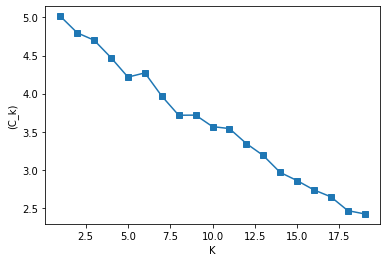

In [28]:
inertia = []
for k in range(1,20,1):
    mbk  = MiniBatchKMeans(n_clusters=k,init='random', random_state=1).fit(tfidf_matrix)
    inertia.append(np.sqrt(mbk.inertia_))
plt.plot(range(1,20,1),inertia,marker='s')
plt.xlabel('K')
plt.ylabel('(C_k)')
plt.show()

***

Алгоритм поиска поставщиков

Для улучшения качества выдачи результата, разумно поиск поставщиков проводить на специализированных площадках (т.н. маркетплейсах), для этого, учитывая их конечное число, предлагается модуль поиска поставщиков конкретной номенклатурной позиции. Модуль реализован в виде интерфейса, принимающего на вход номенклатурную позицию (запрос) и возращает Pandas Dataframe 

In [96]:
def get_company_list_by_product_metalloprokat(product_name):
    # парсер www.metalloprokat.ru

    TARGET_URL = 'https://www.metalloprokat.ru/company/?q='

    sellers = dict()

    site_raw = requests.get(TARGET_URL+product_name, headers=headers).text
    parsed = bs(site_raw, features='lxml')
    comp_count = int(parsed.find_all('div', {'id': 'tabs'})[
                     0].find_all('span', {'class': 'count'})[1].text)

    if comp_count < 1:
        return sellers

    companies = parsed.find_all('div', {'class': 'title'})

    for company in companies:
        try:
            seller_name = company.find_all('a')[0].text[1:-1]
            sellers[seller_name] = []
            sellers[seller_name].append(company.find_all('a')[0]['href'])
        except:
            pass

    reviews = parsed.find_all(
        'li', {'class': 'links_comment item medium float-left clearfix'})
    for review in reviews:
        try:
            print(review.a['data-href'])
        except:
            pass

    inn = ''

    for seller in sellers:
        try:
            raw_for_inn = requests.get(
                GET_INN_URL+seller+GET_INN_URL_POSFIX, headers=headers)
            parsed = bs(raw_for_inn.text, features='lxml')
            company = parsed.find_all('div', {'class': 'company-item'})[0]
            company_info = company.find_all(
                'div', {'class': 'company-item-info'})[1]
            inn = company_info.find_all('dd')[0].text
        except:
            pass
        sellers[seller].append(inn)

    return sellers


def get_company_list_by_product(product_name):
    # базовый метод для парсинга в который добавляем спец парсеры
    sellers = get_company_list_by_product_metalloprokat(product_name)
    result = pd.DataFrame(columns=['Товар', 'Поставщик', 'ИНН'])
    for seller in sellers.keys():
        new_line = {'Товар': product_name,
                    'Поставщик': seller, 'ИНН': sellers[seller]}
        result = result.append(new_line, ignore_index=True)
    return result


In [97]:
search_results = pd.DataFrame(columns=['Товар', 'Поставщик', 'ИНН'])
for element in input_data['Наименование']:
    search_results = search_results.append(get_company_list_by_product(element), ignore_index=True)

search_results

IndexError: list index out of range

***
Процедура обогащения профиля поставщика доп. данными

Модуль получает на вход ИНН организации, после чего произвводит обогащение данными, необходимыми для работы алгоритма приоретизации поставщика (размер уставного капитала, прибыль/убыток до налогообложения, прибыль/убыток от продаж) и возвращает Pandas Dataframe с соответствующими полями.

In [94]:
def addDataToSeller(seller_inn):
    result = pd.DataFrame(columns=['Наименование', 'ИНН', 'Уставной капитал', 'Основной ОКВЭД',
                                   'Описание ОКВЭД', 'Статус ЮЛ', 'Дата назначения статуса'])

    full_caption = 'нет данных'
    ust_capitall = 'нет данных'
    main_okved_code = 'нет данных'
    main_okved_descr = 'нет данных'
    status_desc = 'нет данных'
    status_date = 'нет данных'
    income = 'нет данных'
    outcome = 'нет данных'

    req_ansv = requests.get(EGRUL_URL+seller_inn+'.json')
    if req_ansv.status_code != 200:
        return
    seller_nalog_data = json.loads(req_ansv.text)
    if 'СвЮЛ' in seller_nalog_data.keys():
        if 'СвНаимЮЛ' in seller_nalog_data['СвЮЛ']:
            full_caption = seller_nalog_data['СвЮЛ']['СвНаимЮЛ']['@attributes']['НаимЮЛПолн']
        if 'СвУстКап' in seller_nalog_data['СвЮЛ']:
            ust_capitall = seller_nalog_data['СвЮЛ']['СвУстКап']['@attributes']['СумКап']
        if 'СвОКВЭД' in seller_nalog_data['СвЮЛ']:
            main_okved_code = seller_nalog_data['СвЮЛ']['СвОКВЭД']['СвОКВЭДОсн']['@attributes']['КодОКВЭД']
            main_okved_descr = seller_nalog_data['СвЮЛ']['СвОКВЭД']['СвОКВЭДОсн']['@attributes']['НаимОКВЭД']
        if 'СвСтатус' in seller_nalog_data['СвЮЛ']:
            status_desc = seller_nalog_data['СвЮЛ']['СвСтатус']['СвСтатус']['@attributes']['НаимСтатусЮЛ']
            status_date = seller_nalog_data['СвЮЛ']['СвСтатус']['ГРНДата']['@attributes']['ДатаЗаписи']
    if 'fin' in seller_nalog_data.keys():
        if 'y2018' in seller_nalog_data['fin']:
            income = seller_nalog_data['fin']['y2018']['@attributes']['income']
            outcome = seller_nalog_data['fin']['y2018']['@attributes']['outcome']
            


    new_line = {'Наименование': full_caption,
                'ИНН': seller_inn,
                'Уставной капитал': ust_capitall,
                'Основной ОКВЭД': main_okved_code,
                'Описание ОКВЭД': main_okved_descr,
                'Статус ЮЛ': status_desc,
                'Дата назначения статуса': status_date,
                'Дебет': income,
                'Кредит': outcome}

    result = result.append(new_line, ignore_index=True)

    return result


Пример выявления организации в отношении которого начата процедуре банкротсва:

In [95]:
addDataToSeller('7721024057')

,Наименование,ИНН,Уставной капитал,Основной ОКВЭД,Описание ОКВЭД,Статус ЮЛ,Дата назначения статуса,Дебет,Кредит
0,"ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""КАРАЧАРОВСКИЙ ...",7721024057,89120,28.22.6,"Производство лифтов, скриповых подъемников, эс...",В отношении юридического лица в деле о несосто...,2021-02-21,7183547000,5461582000


In [100]:
# TODO: Добавить датафрейм по полученным ранее поставщикам!
search_results['Наименование'] = None
search_results['ИНН'] = None
search_results['Уставной капитал'] = None
search_results['Основной ОКВЭД'] = None
search_results['Описание ОКВЭД'] = None
search_results['Статус ЮЛ'] = None
search_results['Дата назначения статуса'] = None

for i in range(len(search_results['ИНН'])):
    tmp = addDataToSeller(search_results['ИНН'][i])
    search_results['Наименование'] = tmp['Наименование']
    search_results['ИНН'] = tmp['ИНН']
    search_results['Уставной капитал'] = tmp['Уставной капитал']
    search_results['Основной ОКВЭД'] = tmp['Основной ОКВЭД']
    search_results['Описание ОКВЭД'] = tmp['Описание ОКВЭД']
    search_results['Статус ЮЛ'] = tmp['Статус ЮЛ']
    search_results['Дата назначения статуса'] = tmp['Дата назначения статуса']
    search_results['Дебет'] = tmp['Дебет']
    search_results['Кредит'] = tmp['Кредит']

search_results

,Товар,Поставщик,ИНН,Наименование,Уставной капитал,Основной ОКВЭД,Описание ОКВЭД,Статус ЮЛ,Дата назначения статуса


***
ML - модель приоретизации поставщика 

В качестве скоринг-фактора была выбрана верятность появления просроченной дебиторской задолженности. Модель была обучена на основании данных, предоставленных в рамках задания №4 хакатона.


In [ ]:
def rank_companies(pd):
    # As input we shoud get pandas table 
    # with columns 'a', 'b', 'c',
    # which are "Ustavnyj kapital", "Debitorskajazadolzhennost"," Kreditorskajazadolzhennost"
    import lightgbm as lgb
    gbm = lgb.Booster(model_file='ranker.1txt')
    y_pred = gbm.predict(pd, num_iteration=gbm.best_iteration)
    pd['pdz'] = y_pred
    pd.sort_values('pdz', inplace=True)
    
    return pd


=
test_table = search_results[['Уставной капитал','Дебет','Кредит']]

ranked_table = rank_companies(test_table)
search_results['Cкоринг'] = None
for i in range(len(ranked_table['pdz`'])):
    #TODO: вставить алгоритм добавления скоринга поставщикам в соответствующий столбец фрейма search_results
    pass